In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import os
import collections
import dscrutils2py as dscrutils
import dsc_extract

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from pymir import mpl_stylesheet
from pymir import mpl_utils
from pymir import pd_utils

import methodprops
import methodplots

mpl_stylesheet.banskt_presentation(splinecolor = 'black')

In [2]:
dsc_outdir = os.path.realpath("../dsc/dsc_result_changepoint")
dims       = (500, 500)
targets    = ["changepoint", "changepoint.dims", "changepoint.se", "changepoint.sfix", 
              "changepoint.basis_k", "changepoint.snr",
              "fit_cpt", "fit_cpt.DSC_TIME", "mse.err"]
# methods = ["ridge", "lasso", "lasso_1se", "elastic_net",
#            "elastic_net_1se", "l0learn", "scad", "mcp", 
#            "susie", "varbvs", "blasso", "bayesb",
#            "mr_ash", "mr_ash_init", "em_vamp", "em_vamp_ash"]
methods = ["ridge", "elastic_net", "mr_ash", "ebmr_lasso", "em_iridge"]
conditions = None
orders = [0, 1, 2]
knots  = [1, 2]
#conditions = [f"$(fit) == '{method}'"]
groups = ["fit:"]

In [3]:
dscout = dscrutils.dscquery(dsc_outdir, targets, groups = groups)
dscout['score1'] = np.sqrt(dscout['mse.err'])/dscout['changepoint.se']

INFO: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


[1] "fit:"
Calling: dsc-query /home/saikat/Documents/work/ebmr/simulation/eb-linreg-dsc/dsc/dsc_result_changepoint -o /tmp/Rtmp6J7JtK/filece3ba61ba038e.csv --target "changepoint changepoint.dims changepoint.se changepoint.sfix changepoint.basis_k changepoint.snr fit_cpt fit_cpt.DSC_TIME mse.err" --force -g "fit:" 
Loaded dscquery output table with 5760 rows and 11 columns.



In [5]:
dscout

,DSC,changepoint.dims,changepoint.se,changepoint.sfix,changepoint.basis_k,changepoint.snr,fit_cpt,fit_cpt.DSC_TIME,mse.err,score1
0,1,"(200,500)",0.039566,1,0,20,em_vamp_ash,0.326330,5.281325e-03,1.836738e+00
1,1,"(200,500)",0.102289,2,0,20,em_vamp_ash,1.127804,4.558026e+01,6.600205e+01
2,1,"(200,500)",0.068122,4,0,20,em_vamp_ash,1.079699,1.832763e-02,1.987307e+00
3,1,"(200,500)",0.056068,6,0,20,em_vamp_ash,1.018948,1.669430e-02,2.304442e+00
4,1,"(200,500)",0.138716,8,0,20,em_vamp_ash,1.383391,1.236974e-01,2.535439e+00
...,...,...,...,...,...,...,...,...,...,...
5755,20,"(200,500)",0.050410,6,2,20,em_vamp,1.172657,1.274125e+20,2.239189e+11
5756,20,"(200,500)",0.149940,8,2,20,em_vamp,1.336136,2.258277e+21,3.169361e+11
5757,20,"(200,500)",0.150892,10,2,20,em_vamp,0.697598,6.014342e+22,1.625279e+12
5758,20,"(200,500)",0.105016,15,2,20,em_vamp,0.835440,1.030212e+22,9.665124e+11


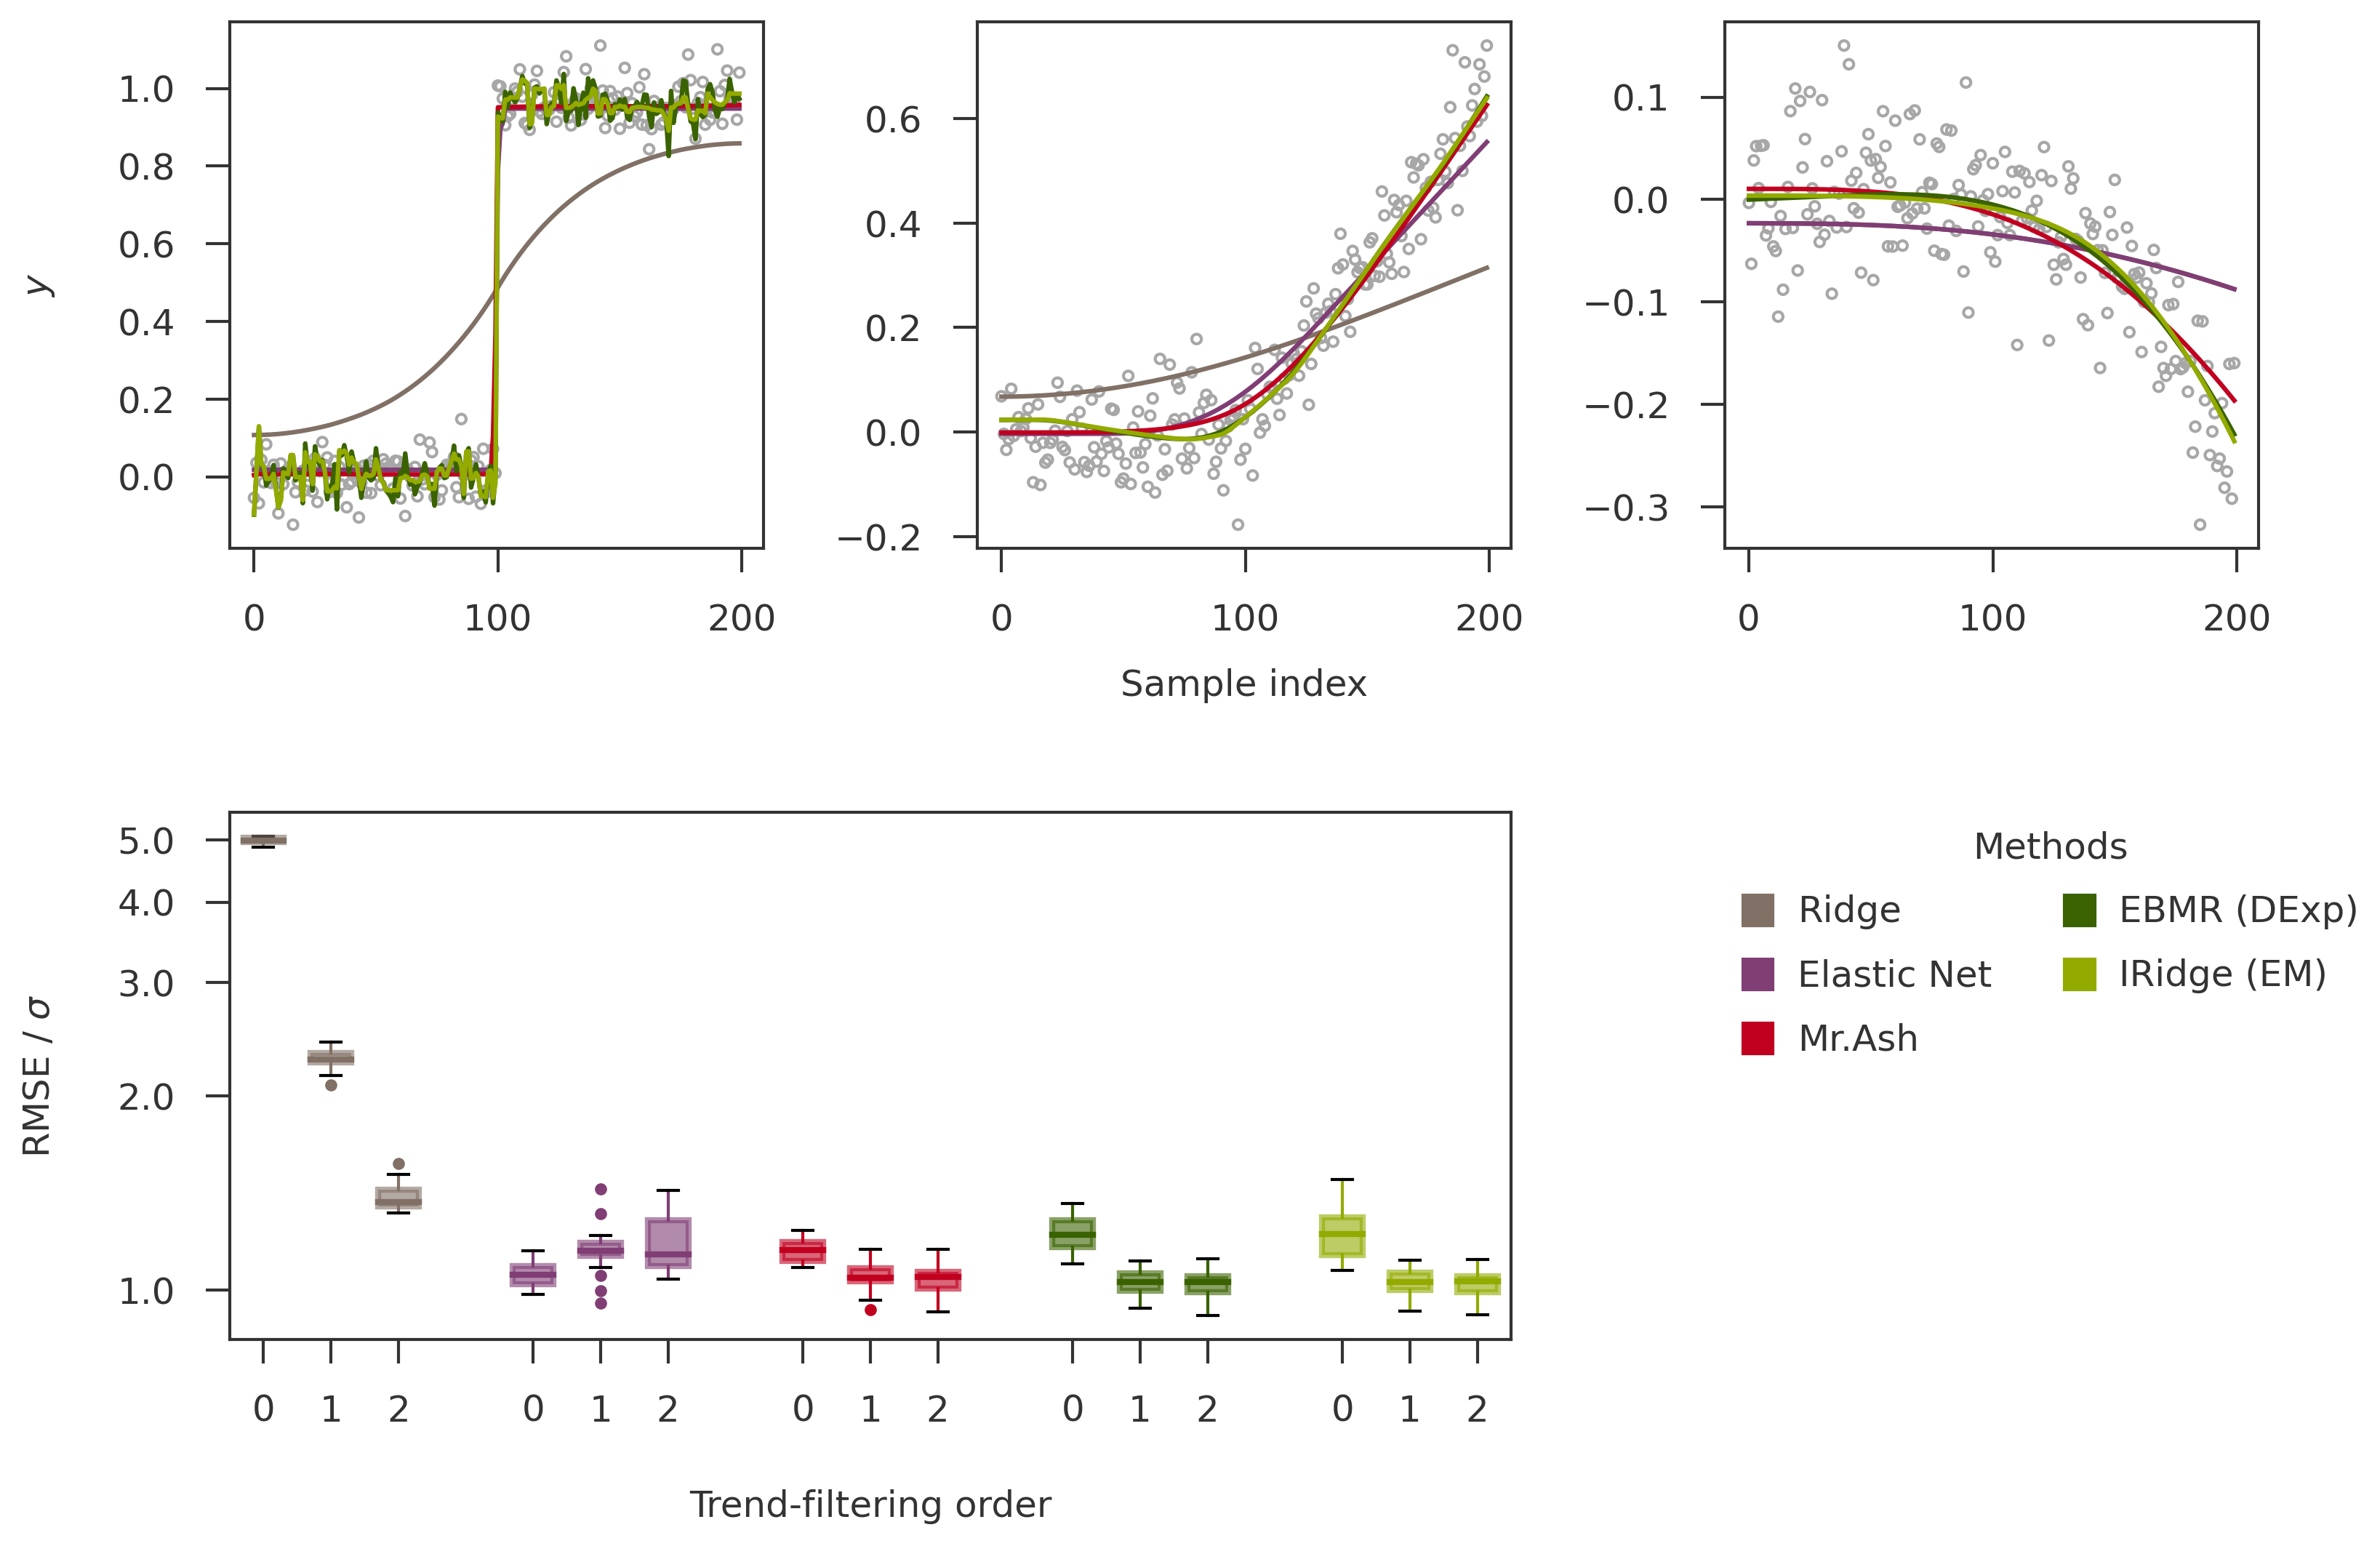

In [12]:
class HandlerSquare(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        #center = xdescent + 0.5 * (width - height), ydescent + 0.5 * (width - height)
        center = xdescent, ydescent - 2.0#+ 0.5 * (width - height)
        p = mpatches.Rectangle(xy=center, width=height, # width = height for square
                               height=height, angle=0.0)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
def get_mse_err_dsc(dscout, colname, method, orders, s = 1):
    conditions = [f"$(fit_cpt) == {method}", f"$(changepoint.sfix) == {s}"]
    mdata   = pd_utils.select_dfrows(dscout, conditions)
    mselist = list()
    for order in orders:
        mse = pd_utils.select_dfrows(mdata, [f"$(changepoint.basis_k) == {order}"])[colname].to_numpy()
        mselist.append(np.log10(mse))
    return mselist

def trend_filter_example_plot(dsc_outdir, dscout, methods, sfix, orders, plot_iter, colname = 'score1'):
    
    figw = 12
    figh = 8
    nrow = 2
    ncol = 3
    wspace = 0.4
    hspace = 0.5
    
    
    # Main plot structure
    mpl_stylesheet.banskt_presentation(splinecolor = 'black', fontsize = 12, splinewidth = 1, dpi = 300)
    fig = plt.figure(figsize = (figw, figh))
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(wspace = wspace, hspace = hspace)

    # Examples
    axlist = list()
    mhandles = list()
    mlabels = list()
    for i, order in enumerate(orders):
        ax = fig.add_subplot(gs[0, i])
        X, y, Xtest, ytest, beta, se, ypred, b0pred, b1pred \
            = dsc_extract.changepoint_predictions(dsc_outdir, methods, 
                                                  order = order, sfix = sfix, dsc_iter = plot_iter[order])
        ax.scatter(np.arange(y.shape[0]), ytest, color = '#A7A7A7', facecolor = 'None', s = 10)
        for method in methods: 
            pm = methodprops.plot_metainfo()[method]
            ax.plot(np.arange(y.shape[0]), ypred[method], color = pm.color, label = pm.label)
            if i == 0:
                mhandles.append(mpatches.Rectangle((0,0), 20, 20, **{'color': pm.color}))
                mlabels.append(pm.label)
        axlist.append(ax)

    # Square errors boxplot
    axc = fig.add_subplot(gs[1, :ncol - 1])
    norder = len(orders)
    xticks  = [j*(norder+1) + i for j in range(len(methods)) for i in range(norder)]
    xticklabels = [i for j in range(len(methods)) for i in range(norder)]
    for j, method in enumerate(methods):
        pm   = methodprops.plot_metainfo()[method]
        mse  = get_mse_err_dsc(dscout, colname, method, orders, s = 1)
        xpos = xticks[j*norder:(j+1)*norder]
        boxprops     = dict(linewidth = 2, color = pm.color, facecolor = pm.color, alpha = 0.6)
        medianprops  = dict(linewidth = 2, color = pm.color)
        whiskerprops = dict(color = pm.color)
        flierprops   = dict(marker = 'o', markerfacecolor = pm.color, markersize=4,
                            markeredgewidth = 0, markeredgecolor = pm.color)
        boxp = axc.boxplot(mse, positions = xpos, widths = 0.6, showfliers = True, showcaps = True,
                           patch_artist = True, boxprops = boxprops, 
                           medianprops = medianprops, whiskerprops = whiskerprops, flierprops = flierprops)
    axc.set_xticks(xticks, minor = False)
    axc.set_xticklabels(xticklabels)    
    mpl_utils.set_yticks(axc, scale = 'log10', kmin = 3, kmax = 4, spacing = 'linear')

    # Legend
    axl = fig.add_subplot(gs[1, ncol - 1])
    axl.tick_params(bottom = False, left = False, labelbottom = False, labelleft = False)
    legendtitle = 'Methods'
    mhandler_map = dict()
    for x in mhandles:
        mhandler_map[x] = HandlerSquare()
    legend1 = axl.legend(handles = mhandles, labels = mlabels, handler_map = mhandler_map, ncol = 2,
                         loc = 'upper left', bbox_to_anchor = (0, 1.0), frameon = False, title = legendtitle)
    mpl_utils.decorate_axes(axl, hide = ["all"], ticklimits = False)

    # Axes labels
    axlist[0].set_ylabel(r"$y$")
    axlist[1].set_xlabel(r"Sample index", labelpad = 10)
    axc.set_ylabel(r"RMSE / $\sigma$")
    axc.set_xlabel("Trend-filtering order")

    plt.show()
    
plot_iter = {0: 2, 1: 4, 2: 4}
trend_filter_example_plot(dsc_outdir, dscout, methods, 1, orders, plot_iter, colname = 'score1')

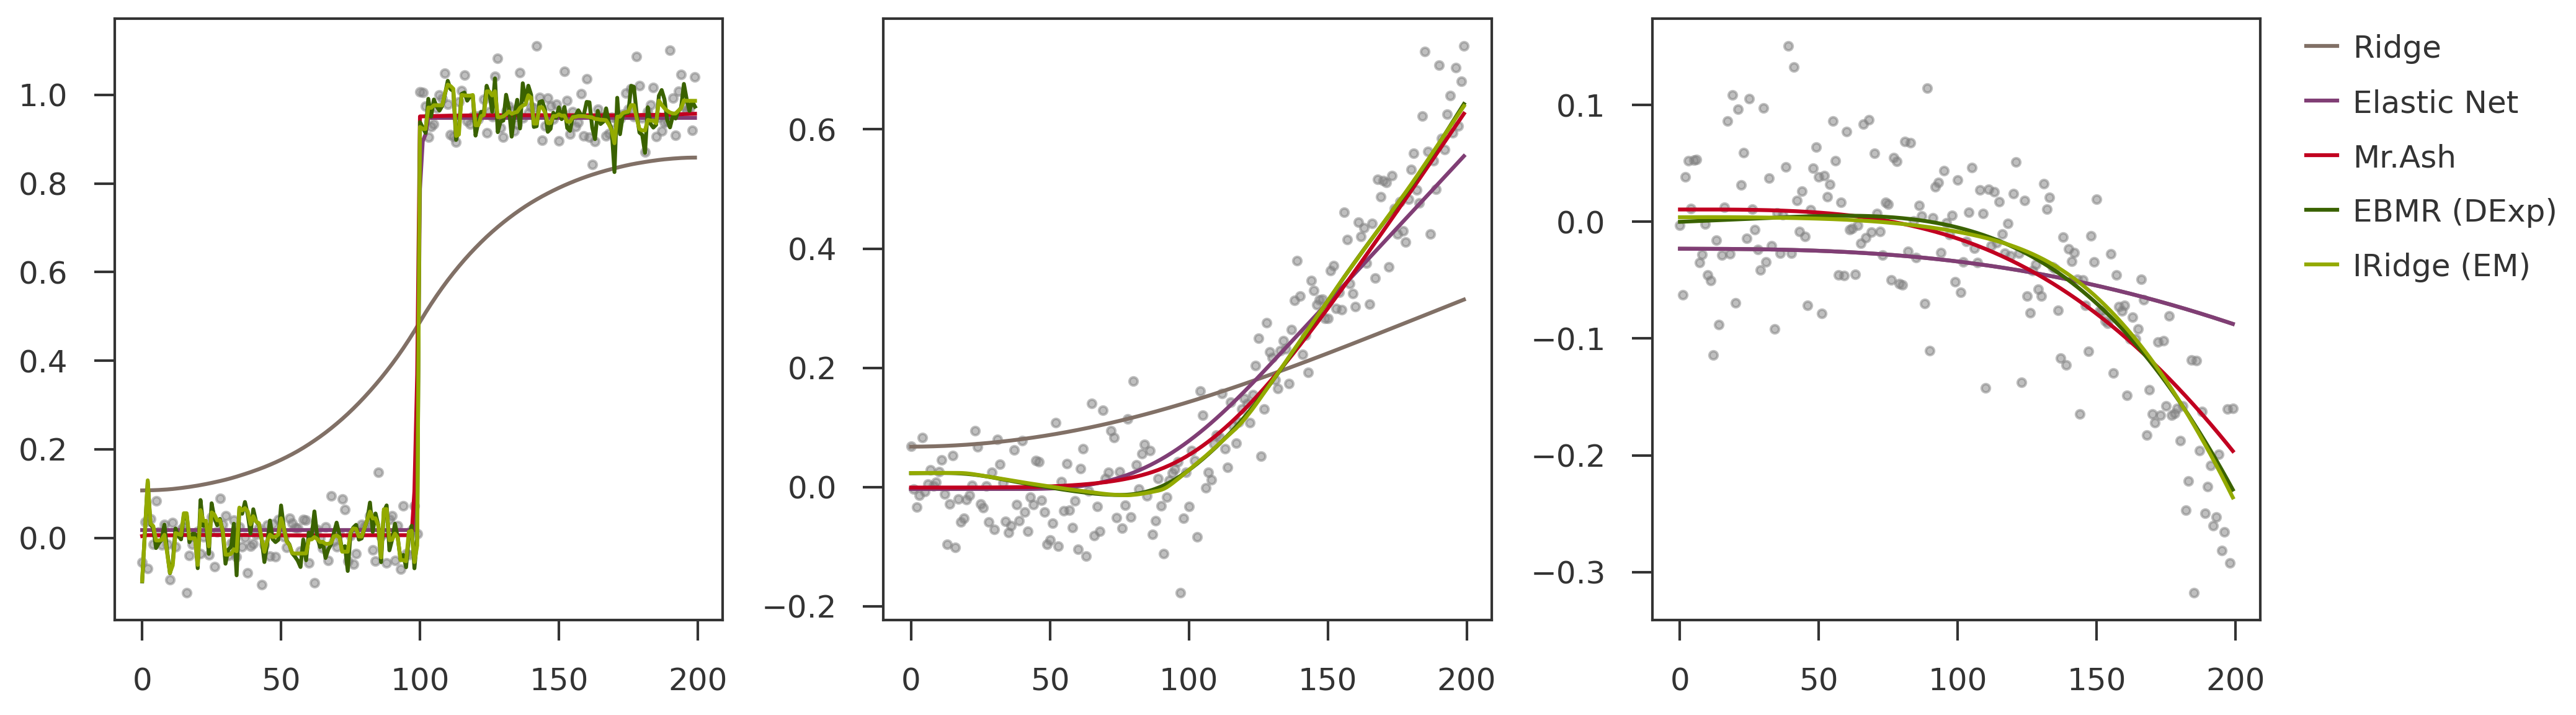

In [69]:
fig = plt.figure(figsize = (14, 4))
ax  = [None for x in orders]

dsc_iter = {0: 2, 1: 4, 2: 4}

for i, order in enumerate(orders):
    ax[i] = fig.add_subplot(1, 3, i + 1)
    X, y, Xtest, ytest, beta, se, ypred, b0pred, b1pred \
        = dsc_extract.changepoint_predictions(dsc_outdir, methods, 
                                              order = order, sfix = 1, dsc_iter = dsc_iter[order])
    n, p = X.shape
    ax[i].scatter(np.arange(n), ytest, alpha = 0.5, color = 'gray', s = 10)
    for method in methods:
        pm = methodprops.plot_metainfo()[method]
        ax[i].plot(np.arange(n), ypred[method], color = pm.color, label = pm.label)
    
ax[2].legend(loc = 'upper left', bbox_to_anchor = (1.05, 1.0),)
plt.tight_layout()
plt.show()